**Imports**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving helper_data.py to helper_data.py
Saving helper_evaluate.py to helper_evaluate.py
Saving helper_plotting.py to helper_plotting.py
Saving helper_train.py to helper_train.py
Saving helper_utils.py to helper_utils.py


**Import utility functions**

In [ ]:
from helper_data import get_dataloaders_celeba
from helper_data import UnNormalize
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:1


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

**Dataset**

In [ ]:
from torchvision import datasets

# Directory to store the CelebA dataset
data_dir = './data'

# Download CelebA dataset
celeba_dataset = datasets.CelebA(data_dir, download=True)

1443490838it [00:10, 139666022.56it/s]
26721026it [00:00, 96128156.66it/s] 
3424458it [00:00, 235050286.99it/s]
6082035it [00:00, 184167084.64it/s]
12156055it [00:00, 110986238.57it/s]
2836386it [00:00, 211297180.35it/s]


In [ ]:
from torchvision import datasets

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CelebA(
    root='/content/data',
    split='train',
    transform=custom_transforms,
    download=False
)

valid_dataset = datasets.CelebA(
    root='/content/data',
    split='valid',
    transform=custom_transforms
)

test_dataset = datasets.CelebA(
    root='/content/data',
    split='test',
    transform=custom_transforms
)


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2
)


Files already downloaded and verified


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry
11 - Brown_Hair
12 - Bushy_Eyebrows
13 - Chubby
14 - Double_Chin
15 - Eyeglasses
16 - Goatee
17 - Gray_Hair
18 - Heavy_Makeup
19 - High_Cheekbones
20 - Male
21 - Mouth_Slightly_Open
22 - Mustache
23 - Narrow_Eyes
24 - No_Beard
25 - Oval_Face
26 - Pale_Skin
27 - Pointy_Nose
28 - Receding_Hairline
29 - Rosy_Cheeks
30 - Sideburns
31 - Smiling
32 - Straight_Hair
33 - Wavy_Hair
34 - Wearing_Earrings
35 - Wearing_Hat
36 - Wearing_Lipstick
37 - Wearing_Necklace
38 - Wearing_Necktie
39 - Young
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive\n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry\n11 - Brown_Hair\n12 - Bushy_Eyebrows\n13 - Chubby\n14 - Double_Chin\n15 - Eyeglasses\n16 - Goatee\n17 - Gray_Hair\n18 - Heavy_Makeup\n19 - High_Cheekbones\n20 - Male\n21 - Mouth_Slightly_Open\n22 - Mustache\n23 - Narrow_Eyes\n24 - No_Beard\n25 - Oval_Face\n26 - Pale_Skin\n27 - Pointy_Nose\n28 - Receding_Hairline\n29 - Rosy_Cheeks\n30 - Sideburns\n31 - Smiling\n32 - Straight_Hair\n33 - Wavy_Hair\n34 - Wearing_Earrings\n35 - Wearing_Hat\n36 - Wearing_Lipstick\n37 - Wearing_Necklace\n38 - Wearing_Necktie\n39 - Young\n'

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def reparameterize(self, z_mu, z_log_var):
      eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
      z = z_mu + eps * torch.exp(z_log_var/2.)
      return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
DEVICE = torch.device('cuda:0')
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

**TRAINNING**

In [ ]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_celeba_02.pt')

Epoch: 001/050 | Batch 0000/0636 | Loss: 5466.5259
Epoch: 001/050 | Batch 0050/0636 | Loss: 2130.4858
Epoch: 001/050 | Batch 0100/0636 | Loss: 1482.9974
Epoch: 001/050 | Batch 0150/0636 | Loss: 1221.6599
Epoch: 001/050 | Batch 0200/0636 | Loss: 1061.7052
Epoch: 001/050 | Batch 0250/0636 | Loss: 1029.9342
Epoch: 001/050 | Batch 0300/0636 | Loss: 938.7773
Epoch: 001/050 | Batch 0350/0636 | Loss: 975.2345
Epoch: 001/050 | Batch 0400/0636 | Loss: 931.5921
Epoch: 001/050 | Batch 0450/0636 | Loss: 914.6050
Epoch: 001/050 | Batch 0500/0636 | Loss: 915.7692
Epoch: 001/050 | Batch 0550/0636 | Loss: 862.8069
Epoch: 001/050 | Batch 0600/0636 | Loss: 845.5339
Time elapsed: 3.29 min
Epoch: 002/050 | Batch 0000/0636 | Loss: 823.7566
Epoch: 002/050 | Batch 0050/0636 | Loss: 792.5617
Epoch: 002/050 | Batch 0100/0636 | Loss: 825.2006
Epoch: 002/050 | Batch 0150/0636 | Loss: 789.5089
Epoch: 002/050 | Batch 0200/0636 | Loss: 767.5988
Epoch: 002/050 | Batch 0250/0636 | Loss: 738.5705
Epoch: 002/050 | Batc

In [ ]:
from google.colab import drive
import pickle

# Lưu mô hình vào Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/VAE.pkl'
with open(path, 'wb') as file:
    pickle.dump(VAE(), file)




**EVALUATION**

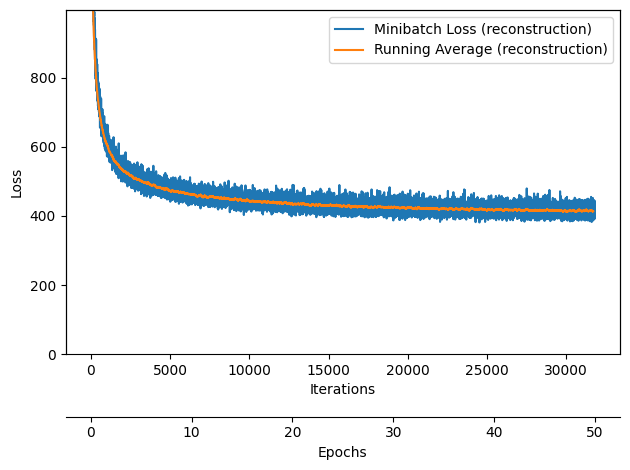

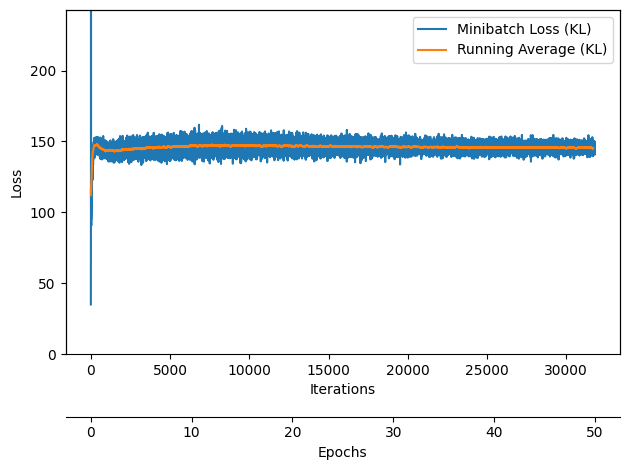

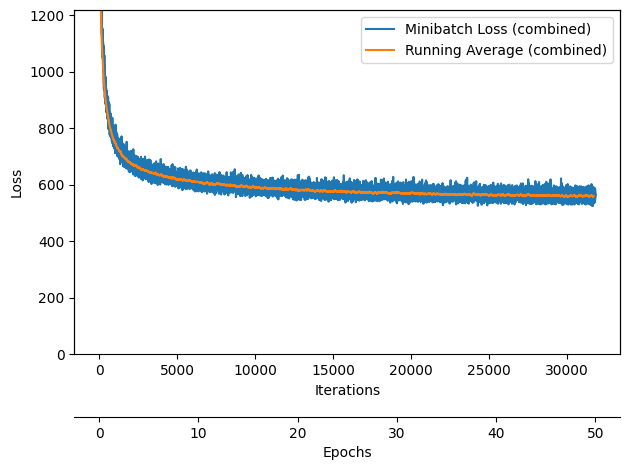

In [ ]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

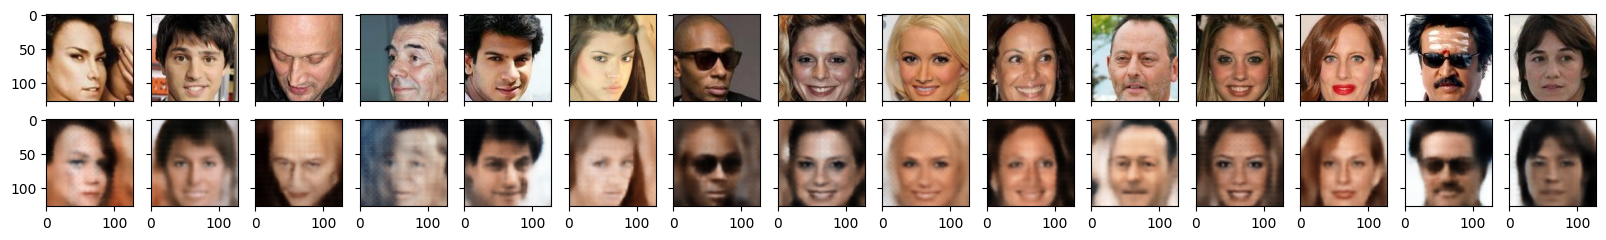

In [ ]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')

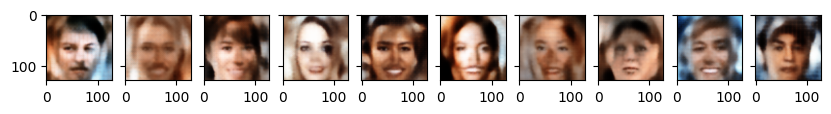

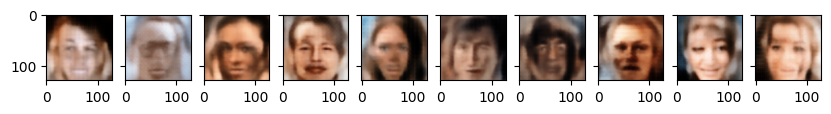

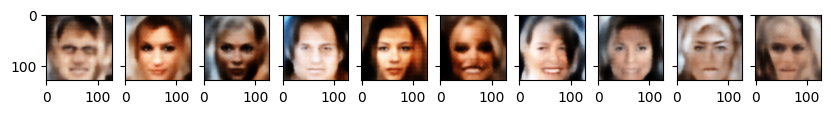

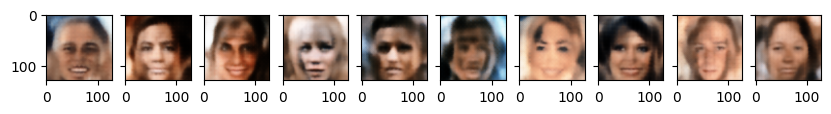

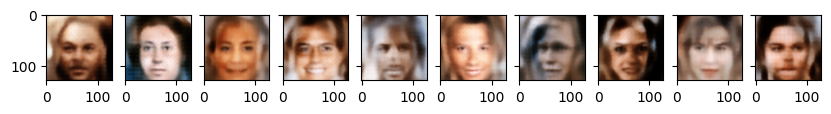

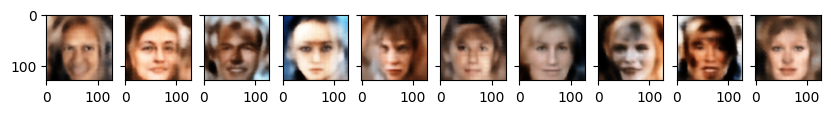

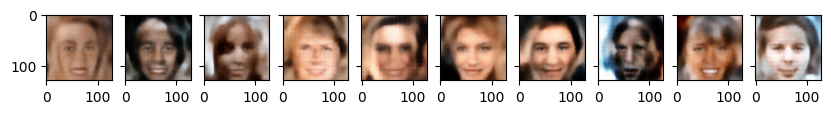

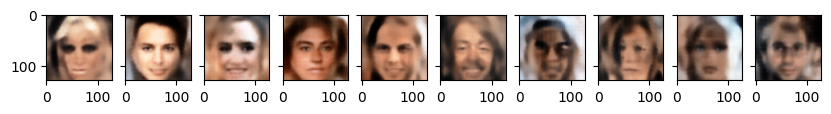

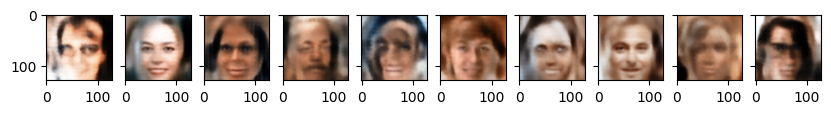

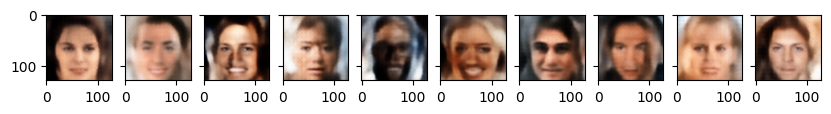

In [ ]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()

**Inspect Latent Dimensions**

In [ ]:
from helper_data import get_dataloaders_celeba

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 5000

Device: cuda:1


In [ ]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Files already downloaded and verified


In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
# Chọn một số thứ tự CUDA hợp lệ
DEVICE = torch.device('cuda:0')  # Thay đổi số thứ tự theo thiết bị CUDA mong muốn

# Sau đó sử dụng số thứ tự được chỉ định khi chuyển tensor
images, labels = images.to(DEVICE), labels.to(DEVICE)
model = model.to(DEVICE)  # Chuyển mô hình về thiết bị CUDA nếu cần

with torch.no_grad():
    images = images.to(DEVICE)  # Chuyển tensor đầu vào về cùng kiểu dữ liệu với trọng số của mô hình
    embeddings = model.encoding_fn(images).to('cpu')



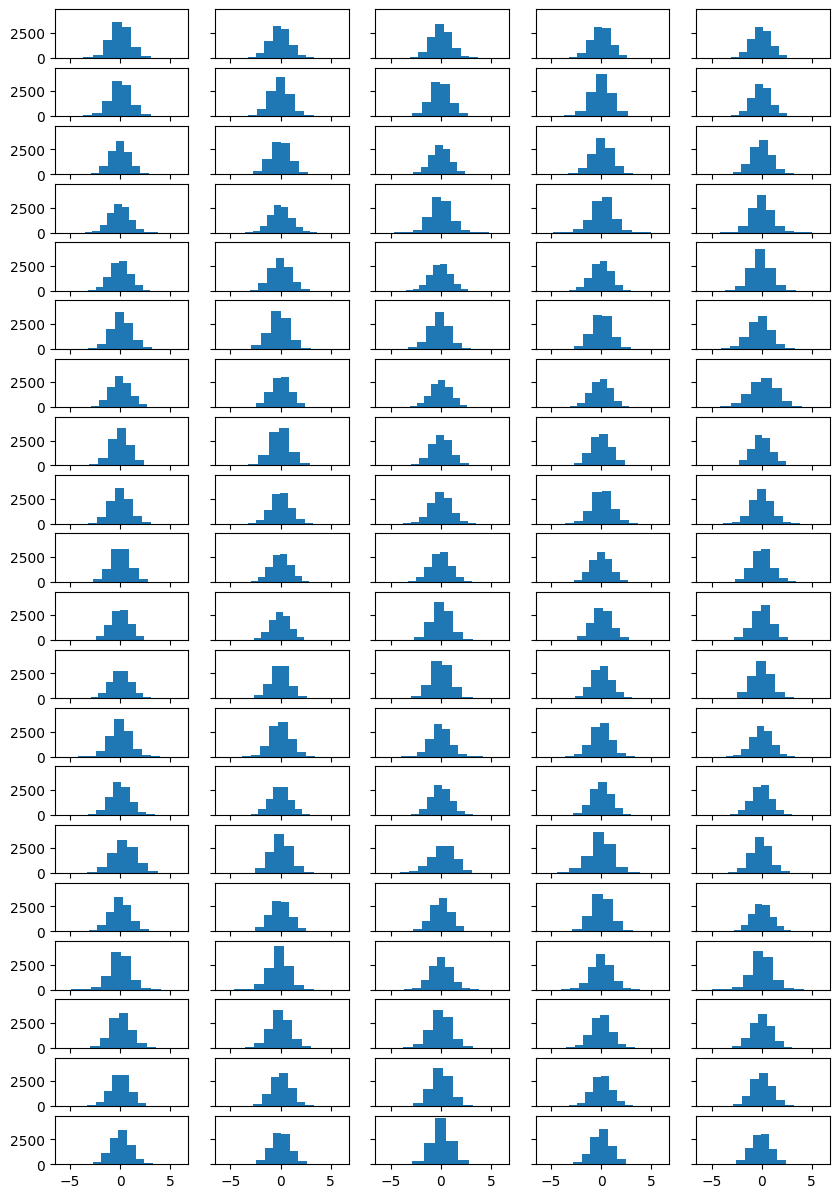

In [ ]:
 #Limit to 10k images
# Chuyển đổi kích thước của tensor 'tensor_a' thành [16, 200]

all_embeddings = torch.zeros((10_000, 200))

num_images = 0
for images, labels in train_loader:

    if num_images >= 10_000:
        break

    begin = num_images
    end = begin + images.size(0)

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        embeddings = model.encoding_fn(images).to('cpu')

    all_embeddings[begin:end] = embeddings

    num_images = end
fig, axes = plt.subplots(nrows=20, ncols=5,
                         sharex=True, sharey=True,
                         figsize=(10, 15))

i = 0
for row in range(len(axes)):
    for col in range(len(axes[0])):
        axes[row][col].hist(all_embeddings[:, i].numpy())
        i += 1

plt.show()

**VAE Latent Space Arithmetic**

In [ ]:
from helper_data import get_dataloaders_celeba
from helper_data import compute_average_faces
from helper_plotting import plot_modified_faces

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 5000

Device: cuda:3


In [ ]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Files already downloaded and verified


In [ ]:
torch.manual_seed(RANDOM_SEED)
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

EXAMPLE_IMAGE = images[1]

Image batch dimensions: torch.Size([5000, 3, 128, 128])
Image label dimensions: torch.Size([5000, 40])


**image Manipulation in Original Space**

Compute Average Faces


In [ ]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=(3, 128, 128),
    data_loader=train_loader,
    device=None,
    encoding_fn=None)

Average Smiling Face

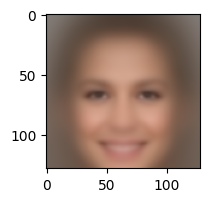

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_with_feat).permute(1, 2, 0))
plt.show()

Average Non-Smiling Face

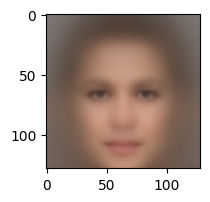

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_without_feat).permute(1, 2, 0))
plt.show()


Manipulate Example Face Image

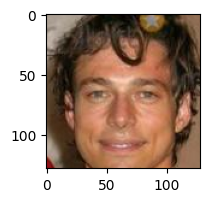

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))

ax.imshow(EXAMPLE_IMAGE.permute(1, 2, 0))
plt.show()

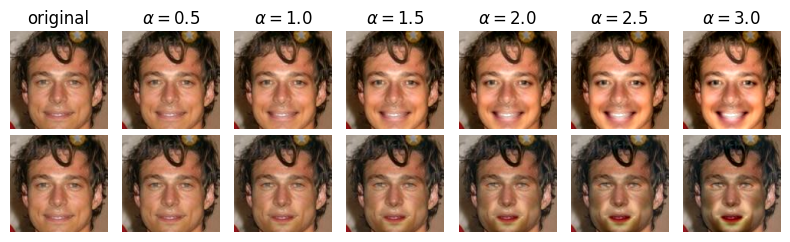

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)
plot_modified_faces(original=images[1],
                    diff=diff)

plt.tight_layout()
plt.show()

**Image Manipulation in Latent Space**

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

load model

In [ ]:
DEVICE = torch.device('cuda:0')  # Thay đổi số thứ tự theo thiết bị CUDA mong muốn

# Sau đó sử dụng số thứ tự được chỉ định khi chuyển tensor
images, labels = images.to(DEVICE), labels.to(DEVICE)
model = model.to(DEVICE)  # Chuyển mô hình về thiết bị CUDA nếu cần

with torch.no_grad():
    images = images.to(DEVICE)  # Chuyển tensor đầu vào về cùng kiểu dữ liệu với trọng số của mô hình
    embeddings = model.encoding_fn(images).to('cpu')


**Compute Average Faces in Latent Space -- More or Less Smiling**

In [ ]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

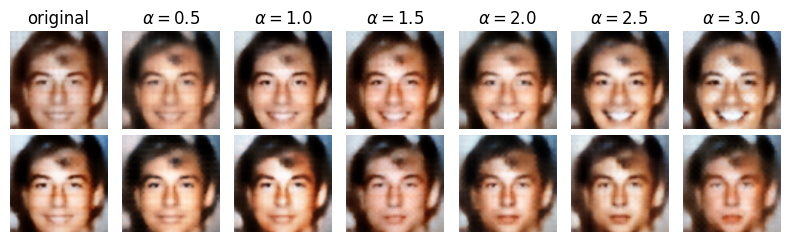

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()

**Compute Average Faces in Latent Space -- With or Without Glasses**

In [ ]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=15, # eyeglasses
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

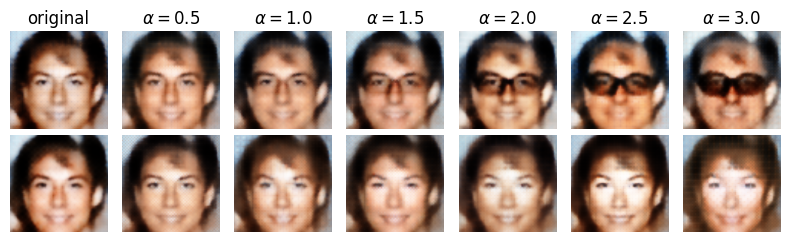

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()